# Outline:


*   **Notebook 1**:

  *   An overview of Federated Learning (FL)
  *   An overview of Whole Slide Image (WSI) data
  *   Kidney WSI data inspection and creation for HFL task
  *   Baseline experiment on kidney patch classification
  *   An experiment setup for comparing HFL against baseline


*   **Notebook 2**:

  *   A working example of Horizontal Federated Learning (HFL) using TensorFlow Federated on histopathology Kidney images
      *   Tensorflow Federated dataset
      *   Tensorflow Federated model
      *   Tensorflow Federated computations for initialization train and validation
  *   Comparison of FederatedAveraging against the baseline scenario

# Notebook 2:
## A working example of Horizontal Federated Learning (HFL) using TensorFlow Federated on histopathology Kidney images


### Installation of packages

In [1]:
!pip install tensorflow-federated==0.18
!pip install nest_asyncio


     |████████████████████████████████| 578 kB 5.3 MB/s 
     |████████████████████████████████| 2.9 MB 37.0 MB/s 
     |████████████████████████████████| 172 kB 28.0 MB/s 
     |████████████████████████████████| 394.5 MB 382 bytes/s 
     |████████████████████████████████| 3.8 MB 33.6 MB/s 
     |████████████████████████████████| 703 kB 51.0 MB/s 
     |████████████████████████████████| 192 kB 44.5 MB/s 
     |████████████████████████████████| 462 kB 52.5 MB/s 
  Attempting uninstall: cachetools
    Found existing installation: cachetools 4.2.4
    Uninstalling cachetools-4.2.4:
      Successfully uninstalled cachetools-4.2.4
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.41.0
    Uninstalling grpcio-1.41.0:
      Successfully uninstalled grpcio-1.41.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  

### Importing Required Packages:

In [2]:
import nest_asyncio
nest_asyncio.apply()

import glob
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import collections
import tensorflow as tf
import tensorflow_federated as tff


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

# Data Loading:

To load the necessary files, specify the "path" variable to be the path to the folder that contains the following files:  
* HFL_kidney.csv
* HFL_dict_data.npy 
* tissue_source_site_data.xlsx
* history_fed_train_id_0_2_3_test_id_1.npy
* my_history_train_id_0_test_id_1.npy
* my_history_train_id_2_test_id_1.npy
* my_history_train_id_3_test_id_1.npy

We already created a dictionary with for key and value pairs for kideny images from the four mentioned hospitals. Each value in dictionary is a tuple of normalized images (normalized to [0-1]  range) and the associated labels for possible three disease types.

In [6]:
# Base path to the folder that contains the following files:  HFL_kidney.csv, HFL_dict_data.npy,  tissue_source_site_data.xlsx, history_fed_train_id_0_2_3_test_id_1.npy,  my_history_train_id_0_test_id_1.npy, my_history_train_id_2_test_id_1.npy, and my_history_train_id_3_test_id_1.npy.
path='/ssd003/projects/pets/datasets'
# Load the meta-data of Kidney dataset
df = pd.read_csv(path+'/HFL_kidney.csv')
data=np.load(path+'/HFL_dict_data.npy',allow_pickle='TRUE').item() # data[0] return the image-lable tuple for hospital number 0

## Creating Federated Data:
The function `tff.simulation.ClientData.from_clients_and_fn`, requires that we write a function that accepts a `client_id` as input and returns a `tf.data.Dataset`. Let's do that in the helper function below: 

In [7]:

batch_size=64
SHUFFLE_BUFFER=128
def create_tf_dataset_for_client_fn(client_id):
    client_data = data[client_id]
    dataset=tf.data.Dataset.from_tensor_slices((client_data[0], client_data[1])).prefetch(buffer_size=128)  #client_data[0] is images,   client_data[1] is labels
    dataset=dataset.shuffle(2000, reshuffle_each_iteration=True).batch(batch_size)
    
    return dataset


Now, let's create the training and testing federated data. There are 4 hospitals in our data. We use data of 3 hospitals for training and 1 hospital for testing.

In [9]:

train_client_ids=[0,2,3]
test_client_ids=[1]


train_data = tff.simulation.ClientData.from_clients_and_fn(client_ids=train_client_ids,   create_tf_dataset_for_client_fn=create_tf_dataset_for_client_fn)
test_data = tff.simulation.ClientData.from_clients_and_fn(
        client_ids=test_client_ids,
        create_tf_dataset_for_client_fn=create_tf_dataset_for_client_fn)




Let's see number of the clients for training federated data and also the sructure of data:

In [ ]:
len(train_data.client_ids)

3

In [ ]:
train_data.element_type_structure

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float16, name=None),
 TensorSpec(shape=(None, 3), dtype=tf.float64, name=None))

To see exactly how one batch od data look like we create the following example dataset from one the client ids of train federated data:

In [ ]:
example_dataset = train_data.create_tf_dataset_for_client(
        train_data.client_ids[0]
    )
#print(example_dataset)
example_element = iter(example_dataset).next()
print(example_element)

(<tf.Tensor: shape=(64, 224, 224, 3), dtype=float16, numpy=
array([[[[0.749 , 0.6665, 0.816 ],
         [0.7803, 0.6943, 0.859 ],
         [0.8   , 0.6943, 0.89  ],
         ...,
         [0.6743, 0.4626, 0.7334],
         [0.6943, 0.4824, 0.745 ],
         [0.7217, 0.51  , 0.7646]],

        [[0.7803, 0.702 , 0.8667],
         [0.792 , 0.71  , 0.886 ],
         [0.7803, 0.686 , 0.898 ],
         ...,
         [0.678 , 0.4785, 0.741 ],
         [0.6943, 0.4902, 0.741 ],
         [0.714 , 0.5137, 0.757 ]],

        [[0.7764, 0.71  , 0.9097],
         [0.784 , 0.71  , 0.9253],
         [0.7725, 0.6904, 0.933 ],
         ...,
         [0.714 , 0.5293, 0.7725],
         [0.7295, 0.541 , 0.7725],
         [0.741 , 0.5527, 0.7803]],

        ...,

        [[0.7764, 0.6743, 0.816 ],
         [0.816 , 0.7256, 0.851 ],
         [0.851 , 0.7686, 0.8667],
         ...,
         [0.757 , 0.655 , 0.8667],
         [0.749 , 0.6274, 0.8276],
         [0.7646, 0.639 , 0.8315]],

        [[0.796 , 0.69

We now have almost all the building blocks in place to construct federated datasets.

One of the ways to feed federated data to TFF in a simulation is simply as a Python list, with each element of the list holding the data of an individual user, as a `tf.data.Dataset`. Since we already have an interface for that, let's use it.

The helper function `make_federated_data` below will construct a list of datasets from the
given set of users as an input to a round of training or evaluation.

In [ ]:
def make_federated_data(client_data, client_ids):
    return [client_data.create_tf_dataset_for_client(x) for x in client_ids]

In [ ]:
federated_train_data = make_federated_data(train_data, train_client_ids)
print('Number of client datasets: {l}'.format(l=len(federated_train_data)))
print('First dataset: {d}'.format(d=federated_train_data[0]))

Number of client datasets: 3
First dataset: <BatchDataset shapes: ((None, 224, 224, 3), (None, 3)), types: (tf.float16, tf.float64)>


## Tensorflow Federated model
Firat we create a model with Keras (which is the same CNN model that we created in notebook 1):


In [ ]:
num_classes = 3
img_height=224
img_width=224
def create_keras_model():
    model = Sequential([
      layers.Conv2D(16, 3, padding='same', activation='relu',input_shape=(img_height, img_width, 3)),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(num_classes,activation='softmax')
    ])
    
    return model

Note that we do not compile the model yet. The loss, metrics, and optimizers are introduced later.

If you have a Keras model like the one we've just defined above, you can have TFF wrap it for you by invoking
`tff.learning.from_keras_model`, passing the model and a sample data batch as
arguments (`input_spec=example_dataset.element_spec`), as shown below.


In [ ]:
# We _must_ create a new model here, and _not_ capture it from an external
# scope. TFF will call this within different graph contexts.
def model_fn():
    keras_model = create_keras_model()

    return tff.learning.from_keras_model(
            keras_model,
            input_spec=example_dataset.element_spec,
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC(name='AUC')])




The model_fn is a no-arg function that returns a `tff.learning.Model`. 

### Training the model on federated data 

Now that we have a model wrapped as `tff.learning.Model` for use with TFF, we
can let TFF construct a **Federated Averaging** algorithm by invoking the helper
function `tff.learning.build_federated_averaging_process`, as follows.

One critical note on the Federated Averaging algorithm below, there are **2**
optimizers: a _client_optimizer_ and a _server_optimizer_. The
_client_optimizer_ is only used to compute local model updates on each client.
The _server_optimizer_ applies the averaged update to the global model at the
server. In particular, this means that the choice of optimizer and learning rate
used may need to be different than the ones you have used to train the model on
a standard i.i.d. dataset.



In [ ]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.01),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.05))

In this case, the two computations generated and packed into iterative_process implement Federated Averaging.

Let's start with the `initialize` computation. As is the case for all federated
computations, you can think of it as a function. The computation takes no
arguments, and returns one result - the representation of the state of the
Federated Averaging process on the server. While we don't want to dive into the
details of TFF, it may be instructive to see what this state looks like. You can
visualize it as follows.

In [ ]:
str(iterative_process.initialize.type_signature)

'( -> <model=<trainable=<float32[3,3,3,16],float32[16],float32[3,3,16,32],float32[32],float32[3,3,32,64],float32[64],float32[50176,128],float32[128],float32[128,3],float32[3]>,non_trainable=<>>,optimizer_state=<int64>,delta_aggregate_state=<value_sum_process=<>,weight_sum_process=<>>,model_broadcast_state=<>>@SERVER)'

While the above type signature may at first seem a bit cryptic, you can recognize that the server state consists of a model (the initial model parameters that will be distributed to all devices), and optimizer_state (additional information maintained by the server, such as the number of rounds to use for hyperparameter schedules, etc.).

Let's invoke the initialize computation to construct the server state.

In [ ]:
state = iterative_process.initialize()

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


In [ ]:
state

ServerState(model=ModelWeights(trainable=[array([[[[ 0.08214223,  0.17868292, -0.03620368, -0.00989941,
          -0.11301883, -0.0098622 ,  0.03028905, -0.11703125,
          -0.12335759, -0.14413926, -0.06961289, -0.15854841,
           0.04545426,  0.17768997, -0.15595332, -0.07009835],
         [ 0.01605965, -0.06967801, -0.1847653 , -0.01635244,
           0.14542106,  0.00660208,  0.04111743,  0.02950254,
          -0.05175823,  0.17122442, -0.08945095,  0.07948756,
           0.13641006, -0.15200776,  0.1589973 ,  0.0462245 ],
         [ 0.11026207,  0.05276459, -0.07039823, -0.03364784,
          -0.11069794,  0.06033954,  0.02114753,  0.08803439,
          -0.10402329, -0.10126594,  0.07106274,  0.04822429,
           0.14033076, -0.1591366 ,  0.10367775,  0.10590681]],

        [[ 0.07209492, -0.12837392,  0.03974092, -0.17739132,
           0.07492948, -0.16285595, -0.17773427, -0.11420213,
          -0.03523411, -0.09817785, -0.07938591, -0.09084755,
          -0.04160431, 

The second of the pair of federated computations, `next`, represents a single
round of Federated Averaging, which consists of pushing the server state
(including the model parameters) to the clients, on-device training on their
local data, collecting and averaging model updates, and producing a new updated
model at the server.

Conceptually, you can think of `next` as having a functional type signature that
looks as follows.

```
SERVER_STATE, FEDERATED_DATA -> SERVER_STATE, TRAINING_METRICS
```

In particular, one should think about `next()` not as being a function that runs on a server, but rather being a declarative functional representation of the entire decentralized computation - some of the inputs are provided by the server (`SERVER_STATE`), but each participating device contributes its own local dataset.

To run a single round of training and visualizing the results We can use the following line of code and federated data we've already generated above:






In [ ]:
state, metrics = iterative_process.next(state, federated_train_data)
print('round  1, metrics={}'.format(metrics))

round  1, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('categorical_accuracy', 0.6682221), ('AUC', 0.8225652), ('loss', 0.80128956)])), ('stat', OrderedDict([('num_examples', 6429)]))])


## Evaluation
To perform evaluation on federated data, you can construct another *federated
computation* designed for just this purpose, using the
`tff.learning.build_federated_evaluation` function, and passing in your model
constructor as an argument. Note that as the evaluation doesn't perform gradient descent, and there's no need to construct
optimizers.

For experimentation and research, when a centralized test dataset is available,
[Federated Learning for Text Generation](federated_learning_for_text_generation.ipynb)
demonstrates another evaluation option: taking the trained weights from
federated learning, applying them to a standard Keras model, and then simply
calling `tf.keras.models.Model.evaluate()` on a centralized dataset.

In [ ]:
evaluation = tff.learning.build_federated_evaluation(model_fn)   # iterative_process = tff.learning.build_federated_averaging_process(model_fn,client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.01), server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.05))


federated_test_data = make_federated_data(test_data, test_client_ids)

val_metrics = evaluation(state.model, federated_test_data)

val_metrics

OrderedDict([('categorical_accuracy', 0.13457331),
             ('AUC', 0.47945976),
             ('loss', 1.1161389)])

In [ ]:
a=iter(federated_test_data[0]).next()
print(a[0].shape)


(64, 224, 224, 3)


## Training and evaluation multiple rounds:

Here we run the federated learning algorithm multiple rounds on training clients and evaluate the performance on test client.

First we initialize the model:

In [ ]:
state = iterative_process.initialize()

Now let's train and evaluate multiple times

In [ ]:
NUM_ROUNDS = 50

loss = list()
accuracy = list()
AUC=list()



val_loss = list()
val_accuracy = list()
val_AUC=list()



evaluation = tff.learning.build_federated_evaluation(model_fn)
federated_test_data = make_federated_data(test_data, test_client_ids)

for round_num in range(1, NUM_ROUNDS+1):
    state, metrics = iterative_process.next(state, federated_train_data)
    val_metrics = evaluation(state.model, federated_test_data)
    
    
    my_loss = metrics['train']['loss']
    loss.append(metrics['train']['loss'])

    
    my_acc = metrics['train']['categorical_accuracy']
    accuracy.append(metrics['train']['categorical_accuracy'])

    my_AUC = metrics['train']['AUC']
    AUC.append(my_AUC)
    
    
    my_val_loss=val_metrics['loss']
    val_loss.append(val_metrics['loss'])

    
    
    my_val_accuracy=val_metrics['categorical_accuracy']
    val_accuracy.append(val_metrics['categorical_accuracy'])
    

    my_val_AUC = val_metrics['AUC']
    val_AUC.append(my_val_AUC)

    print(f"round: {round_num:2d}, training_loss: {my_loss}, training_accuracy: {my_acc}, train_auc: {my_AUC}, test_loss: {my_val_loss}, test_accuracy: {my_val_accuracy},  test_auc: {my_val_AUC}")


history_fed={'loss':loss, 'categorical_accuracy':accuracy, 'AUC':AUC, 'val_loss':val_loss, 'val_categorical_accuracy':val_accuracy, 'val_AUC':val_AUC}


#np.save('/content/gdrive/Shareddrives/AI Engineering/PETs/Privacy-Sobhan Hemati/Kidney/history_fed_train_id_0_2_3_test_id_1.npy',history_fed)

round:  1, training_loss: 0.7951986193656921, training_accuracy: 0.6714885830879211, train_auc: 0.8256200551986694, test_loss: 1.0785291194915771, test_accuracy: 0.6586433053016663,  test_auc: 0.7848511338233948
round:  2, training_loss: 0.792487382888794, training_accuracy: 0.6714885830879211, train_auc: 0.8274843692779541, test_loss: 1.0380213260650635, test_accuracy: 0.7051422595977783,  test_auc: 0.8190912008285522
round:  3, training_loss: 0.7911629676818848, training_accuracy: 0.6711775064468384, train_auc: 0.8280704617500305, test_loss: 1.0024751424789429, test_accuracy: 0.7056892514228821,  test_auc: 0.8354629278182983
round:  4, training_loss: 0.7951035499572754, training_accuracy: 0.6733551025390625, train_auc: 0.8257230520248413, test_loss: 0.9680142998695374, test_accuracy: 0.7056892514228821,  test_auc: 0.8430849313735962
round:  5, training_loss: 0.793380856513977, training_accuracy: 0.6700886487960815, train_auc: 0.8266915678977966, test_loss: 0.9483520984649658, test_ac

KeyboardInterrupt: ignored

## An experiment setup for comparing HFL against baseline

### Train on one hospital and test on another one.
*   We choose hospitals 0,2,3 as training hospitals and hospital 1 as the test hospital
*   For the baseline scenario, we separately train 3 models on each one of 0, 2, and 3 hospitals and test the three models on data of hospital 1
*   For the FL scenario, we train a shared global model on hospitals 0,2, and 3 while clients keep their training data private
*   Then, we compare the performance of the FL model against the baseline

## Comparison of FederatedAveraging against the baseline scenario

In [ ]:

history_fed=np.load(path+'/history_fed_train_id_0_2_3_test_id_1.npy',allow_pickle=True).item()

In [ ]:
train_id=3
test_id=1
history={}
history['{},{}'.format(train_id,test_id)]=np.load(path+'/my_history_train_id_{}_test_id_{}.npy'.format(train_id,test_id),allow_pickle='TRUE').item()

In [ ]:
train_id=2
test_id=1
history['{},{}'.format(train_id,test_id)]=np.load(path+'/my_history_train_id_{}_test_id_{}.npy'.format(train_id,test_id),allow_pickle='TRUE').item()

In [ ]:
train_id=0
test_id=1
history['{},{}'.format(train_id,test_id)]=np.load(path+'/my_history_train_id_{}_test_id_{}.npy'.format(train_id,test_id),allow_pickle='TRUE').item()

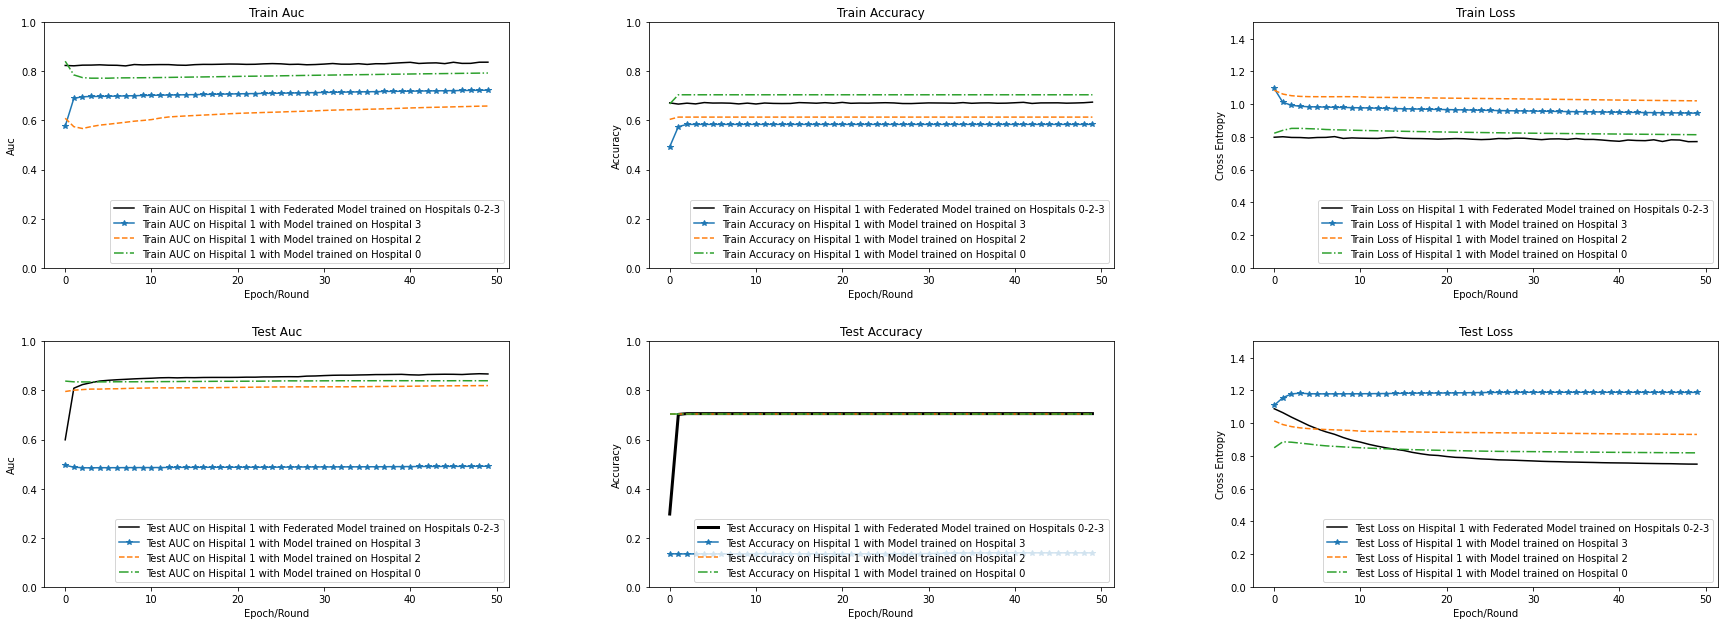

In [ ]:
fig1 = plt.figure(figsize=(30, 8))
fig1.subplots_adjust(top = 0.99, bottom=0.01, hspace=.3, wspace=0.3)
ax1 = fig1.add_subplot(2, 3, 1)
ax1.plot(history_fed['AUC'],color='black',label='Train AUC on Hispital 1 with Federated Model trained on Hospitals 0-2-3')
ax1.plot(history['3,1']['AUC'],'*-',label='Train AUC on Hispital 1 with Model trained on Hospital 3')
ax1.plot(history['2,1']['AUC'], '--', label='Train AUC on Hispital 1 with Model trained on Hospital 2')
ax1.plot(history['0,1']['AUC'], '-.',label='Train AUC on Hispital 1 with Model trained on Hospital 0')
ax1.legend(loc='lower right')
ax1.set_ylabel('Auc')
ax1.set_ylim([0, 1])
ax1.set_title('Train Auc')
ax1.set_xlabel('Epoch/Round')


ax2 = fig1.add_subplot(2, 3, 2)
ax2.plot(history_fed['categorical_accuracy'],color='black',label='Train Accuracy on Hispital 1 with Federated Model trained on Hospitals 0-2-3')
ax2.plot(history['3,1']['categorical_accuracy'],'*-',label='Train Accuracy on Hispital 1 with Model trained on Hospital 3')
ax2.plot(history['2,1']['categorical_accuracy'], '--', label='Train Accuracy on Hispital 1 with Model trained on Hospital 2')
ax2.plot(history['0,1']['categorical_accuracy'], '-.',label='Train Accuracy on Hispital 1 with Model trained on Hospital 0')
ax2.legend(loc='lower right')
ax2.set_ylabel('Accuracy')
ax2.set_ylim([0, 1])
ax2.set_title('Train Accuracy')
ax2.set_xlabel('Epoch/Round')

ax3 = fig1.add_subplot(2, 3, 3)
ax3.plot(history_fed['loss'],color='black',label='Train Loss on Hispital 1 with Federated Model trained on Hospitals 0-2-3')
ax3.plot(history['3,1']['loss'],'*-', label='Train Loss of Hispital 1 with Model trained on Hospital 3')
ax3.plot(history['2,1']['loss'], '--',label='Train Loss of Hispital 1 with Model trained on Hospital 2')
ax3.plot(history['0,1']['loss'], '-.',label='Train Loss of Hispital 1 with Model trained on Hospital 0')

ax3.legend(loc='lower right')
ax3.set_ylabel('Cross Entropy')
ax3.set_ylim([0,max(ax2.get_ylim())+.5])
ax3.set_title('Train Loss')
ax3.set_xlabel('Epoch/Round')



ax4 = fig1.add_subplot(2, 3, 4)
ax4.plot(history_fed['val_AUC'],color='black',label='Test AUC on Hispital 1 with Federated Model trained on Hospitals 0-2-3')
ax4.plot(history['3,1']['val_AUC'],'*-',label='Test AUC on Hispital 1 with Model trained on Hospital 3')
ax4.plot(history['2,1']['val_AUC'], '--', label='Test AUC on Hispital 1 with Model trained on Hospital 2')
ax4.plot(history['0,1']['val_AUC'], '-.',label='Test AUC on Hispital 1 with Model trained on Hospital 0')
ax4.legend(loc='lower right')
ax4.set_ylabel('Auc')
ax4.set_ylim([0, 1])
ax4.set_title('Test Auc')
ax4.set_xlabel('Epoch/Round')


ax5 = fig1.add_subplot(2, 3, 5)
ax5.plot(history_fed['val_categorical_accuracy'],color='black',linewidth=3,label='Test Accuracy on Hispital 1 with Federated Model trained on Hospitals 0-2-3')
ax5.plot(history['3,1']['val_categorical_accuracy'],'*-',label='Test Accuracy on Hispital 1 with Model trained on Hospital 3')
ax5.plot(history['2,1']['val_categorical_accuracy'], '--', label='Test Accuracy on Hispital 1 with Model trained on Hospital 2')
ax5.plot(history['0,1']['val_categorical_accuracy'], '-.',label='Test Accuracy on Hispital 1 with Model trained on Hospital 0')
ax5.legend(loc='lower right')
ax5.set_ylabel('Accuracy')
ax5.set_ylim([0, 1])
ax5.set_title('Test Accuracy')
ax5.set_xlabel('Epoch/Round')

ax6 = fig1.add_subplot(2, 3, 6)

ax6.plot(history_fed['val_loss'],color='black',label='Test Loss on Hispital 1 with Federated Model trained on Hospitals 0-2-3')
ax6.plot(history['3,1']['val_loss'],'*-', label='Test Loss of Hispital 1 with Model trained on Hospital 3')
ax6.plot(history['2,1']['val_loss'], '--',label='Test Loss of Hispital 1 with Model trained on Hospital 2')
ax6.plot(history['0,1']['val_loss'], '-.',label='Test Loss of Hispital 1 with Model trained on Hospital 0')

ax6.legend(loc='lower right')
ax6.set_ylabel('Cross Entropy')
ax6.set_ylim([0,max(ax2.get_ylim())+.5])
ax6.set_title('Test Loss')
ax6.set_xlabel('Epoch/Round')

plt.savefig('/content/gdrive/Shareddrives/AI Engineering/PETs/Privacy-Sobhan Hemati/Kidney/history_fed_train_id_0_2_3_result.jpg',bbox_inches='tight')

In [ ]:
!pip list -v | grep tensorflow-federated
!pip list -v | grep tensorflow


tensorflow-federated          0.19.0              /usr/local/lib/python3.7/dist-packages pip
tensorflow                    2.5.1               /usr/local/lib/python3.7/dist-packages pip
tensorflow-datasets           4.0.1               /usr/local/lib/python3.7/dist-packages pip
tensorflow-estimator          2.5.0               /usr/local/lib/python3.7/dist-packages pip
tensorflow-federated          0.19.0              /usr/local/lib/python3.7/dist-packages pip
tensorflow-gcs-config         2.6.0               /usr/local/lib/python3.7/dist-packages pip
tensorflow-hub                0.12.0              /usr/local/lib/python3.7/dist-packages pip
tensorflow-metadata           1.2.0               /usr/local/lib/python3.7/dist-packages pip
tensorflow-model-optimization 0.5.0               /usr/local/lib/python3.7/dist-packages pip
tensorflow-privacy            0.5.2               /usr/local/lib/python3.7/dist-packages pip
tensorflow-probability        0.14.1              /usr/local/lib/pytho

In [ ]:
from platform import python_version

print(python_version())

3.7.12


In [10]:
!pip list -v | grep tensorflow-federated
!pip list -v | grep tensorflow


tensorflow-federated          0.18.0         /usr/local/lib/python3.7/dist-packages pip
tensorflow                    2.4.3          /usr/local/lib/python3.7/dist-packages pip
tensorflow-addons             0.12.1         /usr/local/lib/python3.7/dist-packages pip
tensorflow-datasets           4.0.1          /usr/local/lib/python3.7/dist-packages pip
tensorflow-estimator          2.4.0          /usr/local/lib/python3.7/dist-packages pip
tensorflow-federated          0.18.0         /usr/local/lib/python3.7/dist-packages pip
tensorflow-gcs-config         2.6.0          /usr/local/lib/python3.7/dist-packages pip
tensorflow-hub                0.12.0         /usr/local/lib/python3.7/dist-packages pip
tensorflow-metadata           1.2.0          /usr/local/lib/python3.7/dist-packages pip
tensorflow-model-optimization 0.5.0          /usr/local/lib/python3.7/dist-packages pip
tensorflow-privacy            0.5.2          /usr/local/lib/python3.7/dist-packages pip
tensorflow-probability        0.